# SAE2 : Communes bretonnes

In [1]:
# Let's burn swome GPUs - Important :  Enable only in CUDA is available, things will break 
%env NETWORKX_AUTOMATIC_BACKENDS=cugraph

env: NETWORKX_AUTOMATIC_BACKENDS=cugraph


In [2]:
# importation des packages
import numpy as np
import pandas as pd
import seaborn as sns
import ast as ast
from geopy.distance import geodesic
import scipy.stats as sps
import networkx as nx
import matplotlib.pyplot as plt


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20,15)

## Le but de ce fichier est construire un graphe networkx à partir de données géolocalisée csv

### 1. Traitement des données csv :

In [3]:
# importation du fichier csv comme un panda dataframe
communes=pd.read_csv("./DonneesFourniesGraphes/voisinageCommunesBretonnes.csv", sep=';')

#on affiche les premières lignes du fichier
communes.head()



insee                  nom  nb_voisins  \
0  22001             Allineuc           5   
1  22002                Andel           5   
2  22003             Aucaleuc           4   
3  22004               Bégard           7   
4  22005  Belle-Isle-en-Terre           5   

                               insee_voisins  
0              22203|22203|22384|22149|22009  
1              22093|22093|22044|22093|22093  
2                    22259|22364|22388|22048  
3  22041|22018|22310|22164|22135|22245|22254  
4              22135|22216|22129|22228|22359

In [4]:
communes.columns


Index(['insee', 'nom', 'nb_voisins', 'insee_voisins'], dtype='object')

In [5]:
# adaptation du format des données en liste des voisins (exemple)
print(communes['insee_voisins'][0])

print(communes.iloc[0,3])

[int(num) for num in communes['insee_voisins'][0].split('|')]


22203|22203|22384|22149|22009
22203|22203|22384|22149|22009


[22203, 22203, 22384, 22149, 22009]

In [6]:
#on enlève les voisins non bretons (22+29+35+56) et les boucles

def amezek(com):
    voisins = [int(num) for num in communes['insee_voisins'][com].split('|')]
    amezek = []
    for vois in voisins :
        if (22000 <= vois and vois<23000) or (29000 <= vois and vois<30000) or (35000 <= vois and vois<36000) or (56000 <= vois and vois<57000) : #on reste en bretagne
            if vois != communes['insee'][com] : #boucle
                if vois not in amezek: # ajout pour éviter les doublons
                    amezek.append(vois)
    return amezek


for x in range(len(communes['insee'])) : 
    amezek(x)

In [7]:
# Création d'un dictionaire représentant la liste des voisins, structure proche des graphes networkx

voisins_dict = {communes['insee'][x] : amezek(x) for x in range(len(communes['insee']))}
voisins_dict[29021]


[29064, 29198, 29091]

### 2. Création d'un graphe en format networkx

In [8]:
#creation directe via l'outil networkx
G = nx.from_dict_of_lists(voisins_dict)

print(len(G.nodes))
#for node in G.nodes:
#    print(node)
    

1197


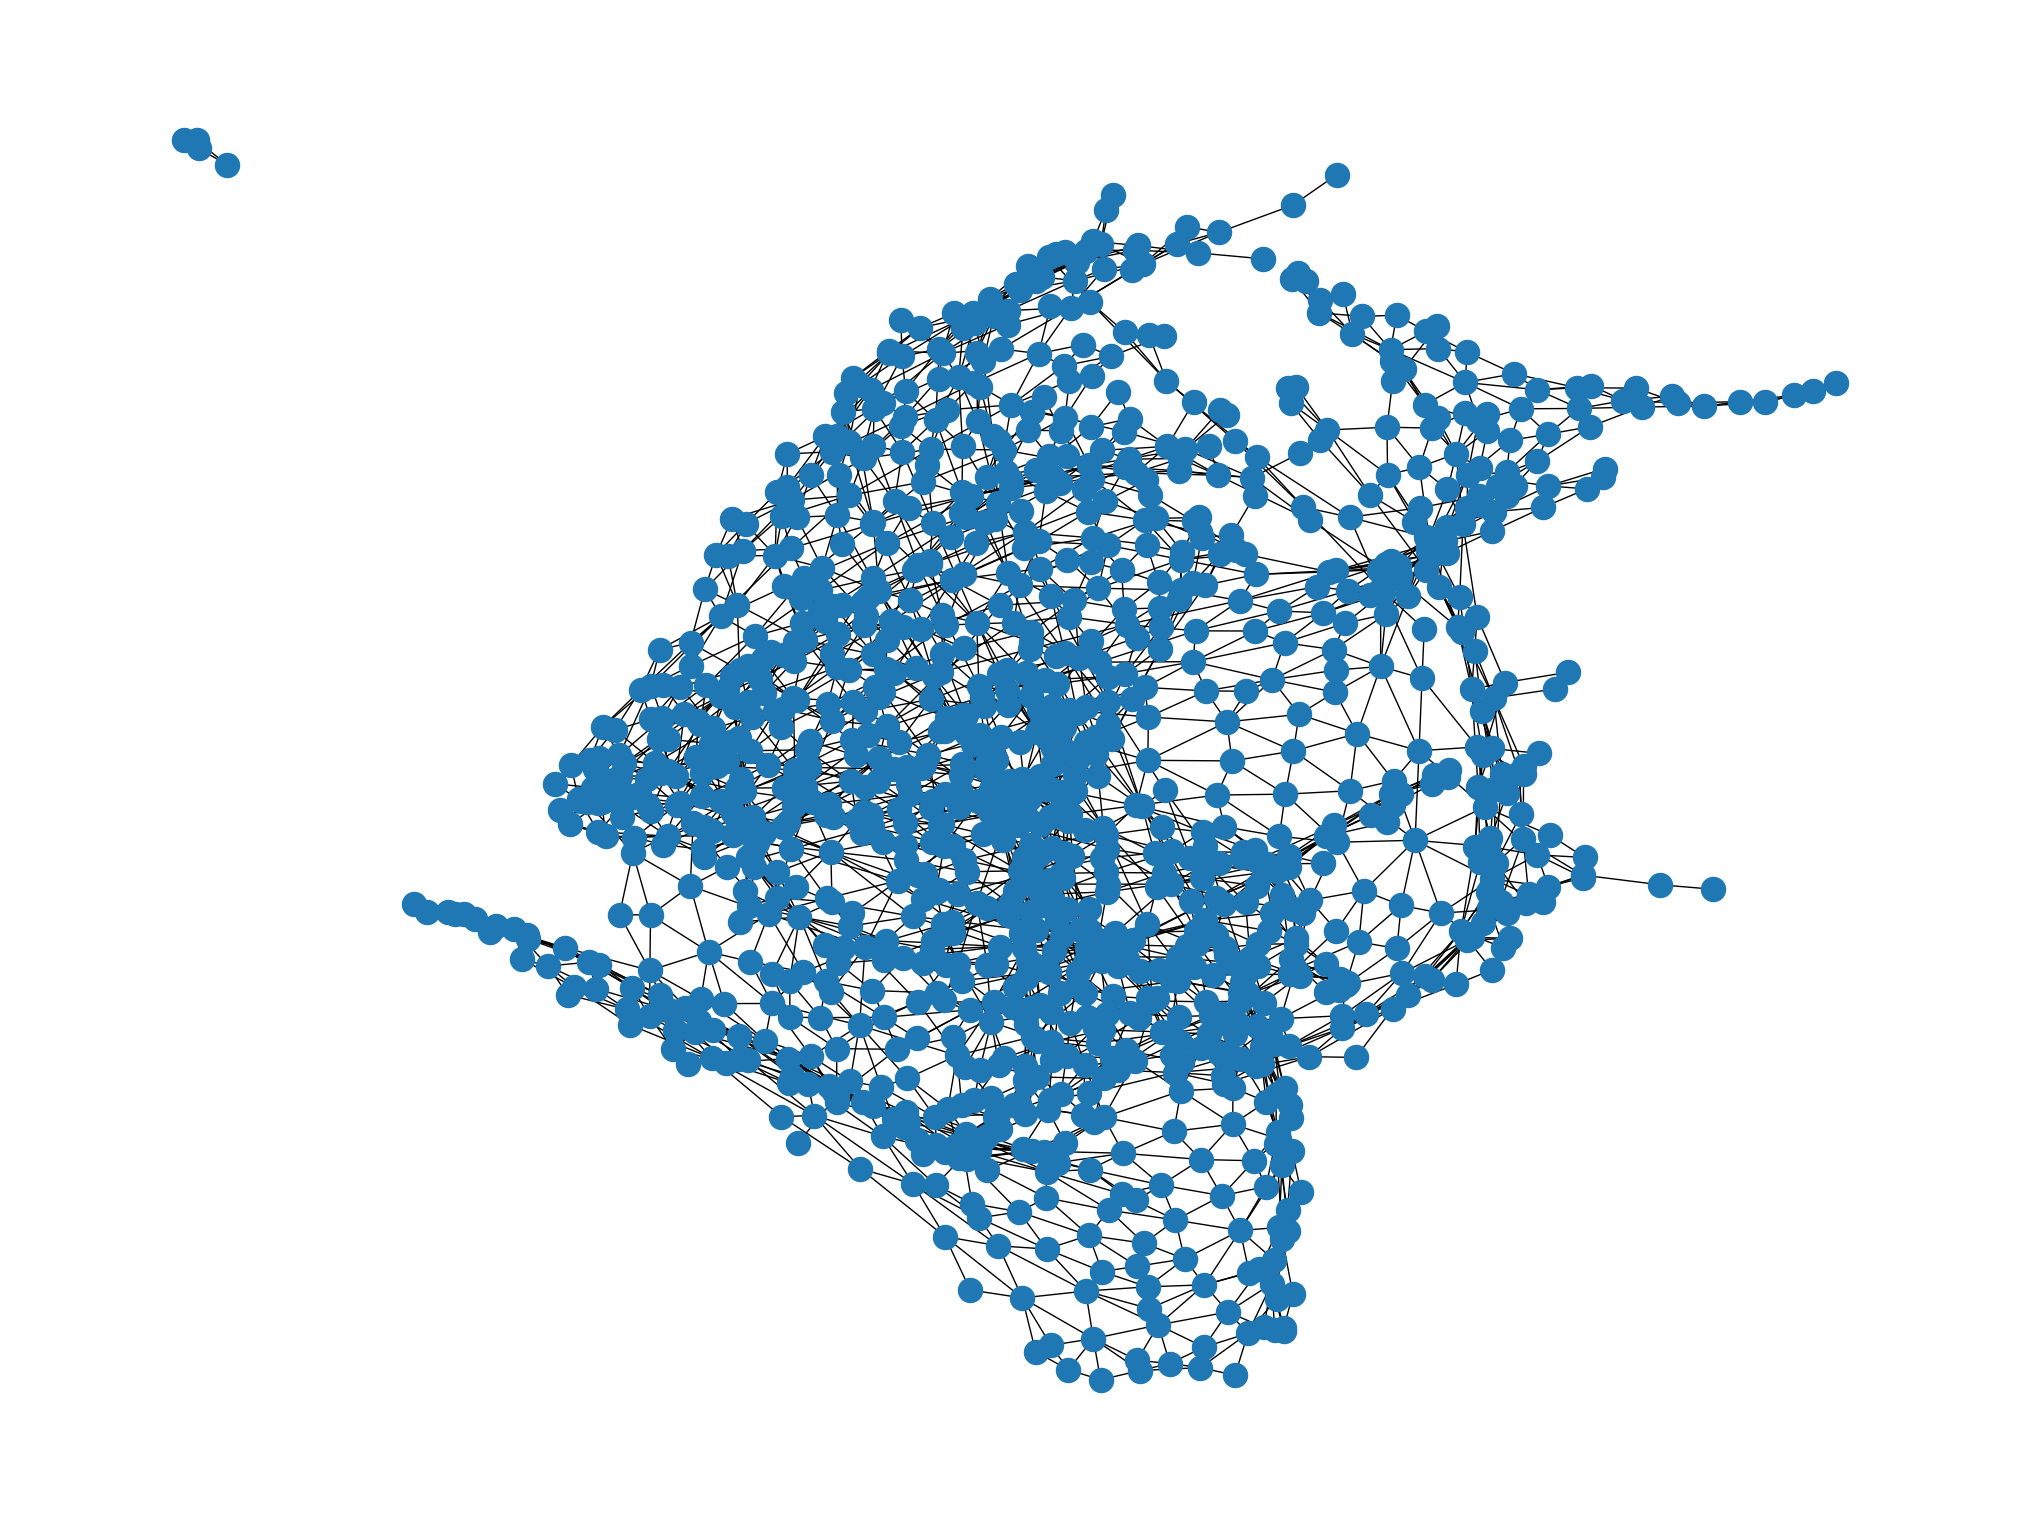

In [9]:
#pour l'instant les sommets ne sont pas placés géographiquement
nx.draw(G,pos=nx.spring_layout(G))


### 3 Exploitation des données géographiques

In [10]:
#lecture des informations geographique

geo=pd.read_csv("./DonneesFourniesGraphes/communes-geo.csv", sep=';')

geo.head()
geo_lite = geo.iloc[:,[0,1,17,19]]

geo_lite.columns

geo_lite['Geo Point'][0]

'47.965835834555435, -2.180339647082372'

In [11]:
# adaptation du format des données de géolocalisation (exemple)
ast.literal_eval(geo_lite['Geo Point'][0])

# création de la colone Latitude
geo_lite['Latitude']=geo_lite['Geo Point'].apply(lambda x : ast.literal_eval(x)[0])
# création de la colone Longitude
geo_lite['Longitude']=geo_lite['Geo Point'].apply(lambda x : ast.literal_eval(x)[1])

geo_lite.head()

Geo Point  \
0   47.965835834555435, -2.180339647082372   
1    48.13658848473797, -3.604143385699294   
2   47.66115932253269, -2.8979142904691706   
3     47.8257861710007, -2.623531946315434   
4  48.561815546029436, -2.3352456790830622   

                                           Geo Shape  Code Officiel Commune  \
0  {"coordinates": [[[-2.138393408174076, 47.9796...                  56012   
1  {"coordinates": [[[-3.598896445577899, 48.0809...                  56066   
2  {"coordinates": [[[-2.914167012351387, 47.6298...                  56167   
3  {"coordinates": [[[-2.559861319644625, 47.7984...                  56172   
4  {"coordinates": [[[-2.340377140698437, 48.5296...                  22268   

  Nom Officiel Commune   Latitude  Longitude  
0              Beignon  47.965836  -2.180340  
1               Gourin  48.136588  -3.604143  
2         Plougoumelen  47.661159  -2.897914  
3             Plumelec  47.825786  -2.623532  
4                 Ruca  48.561816  -2.335246

##### ajout des données géographique

In [12]:
# proposition de dictionaire de position pour le tracé en networkx

def pos_insee(G,data):
    pos = {} #dictionnaire vide
    for com in G.nodes:
        y = float(data[data['Code Officiel Commune'] == com]['Latitude'].iloc[0])
        x = float(data[data['Code Officiel Commune'] == com]['Longitude'].iloc[0])
        #on peut adapter les coordonnées
        #x=(x- 48.13380133652042)*1000
        #y=(y+2.287539276431153)*1000
    
        pos[com]=[x,y]
    
    return pos


pos_insee = pos_insee(G,geo_lite)
#print(pos_insee)

print(len(G.nodes)==len(pos_insee))

print(pos_insee[56167])

True
[-2.8979142904691706, 47.66115932253269]


In [13]:
# proposition de dictionaire de label pour le tracé en networkx

def label_insee(G,data):
    label = {} #dictionnaire vide
    for com in G.nodes:
        lab = data[data['Code Officiel Commune'] == com]['Nom Officiel Commune'].iloc[0]
    
        label[com]=lab
    
    return label

label_insee = label_insee(G,geo_lite)
label_insee

{22001: 'Allineuc',
 22002: 'Andel',
 22003: 'Aucaleuc',
 22004: 'Bégard',
 22005: 'Belle-Isle-en-Terre',
 22006: 'Berhet',
 22055: 'Binic-Étables-sur-Mer',
 22008: 'Bobital',
 22009: 'Le Bodéo',
 22011: 'Boqueho',
 22012: 'La Bouillie',
 22013: 'Bourbriac',
 22014: 'Bourseul',
 22015: 'Bréhand',
 22018: 'Brélidy',
 22019: 'Bringolo',
 22020: 'Broons',
 22021: 'Brusvily',
 22023: 'Bulat-Pestivien',
 22024: 'Calanhel',
 22025: 'Callac',
 22026: 'Calorguen',
 22027: 'Le Cambout',
 22028: 'Camlez',
 22029: 'Canihuel',
 22030: 'Caouënnec-Lanvézéac',
 22031: 'Carnoët',
 22032: 'Caulnes',
 22033: 'Caurel',
 22034: 'Cavan',
 22035: 'Les Champs-Géraux',
 22036: 'La Chapelle-Blanche',
 22037: 'La Chapelle-Neuve',
 22206: 'Châtelaudren-Plouagat',
 22039: 'La Chèze',
 22040: 'Coadout',
 22041: 'Coatascorn',
 22042: 'Coatréven',
 22043: 'Coëtlogon',
 22044: 'Coëtmieux',
 22045: 'Cohiniac',
 22046: 'Le Mené',
 22047: 'Corlay',
 22048: 'Corseul',
 22049: 'Créhen',
 22050: 'Dinan',
 22084: 'Jugon-les

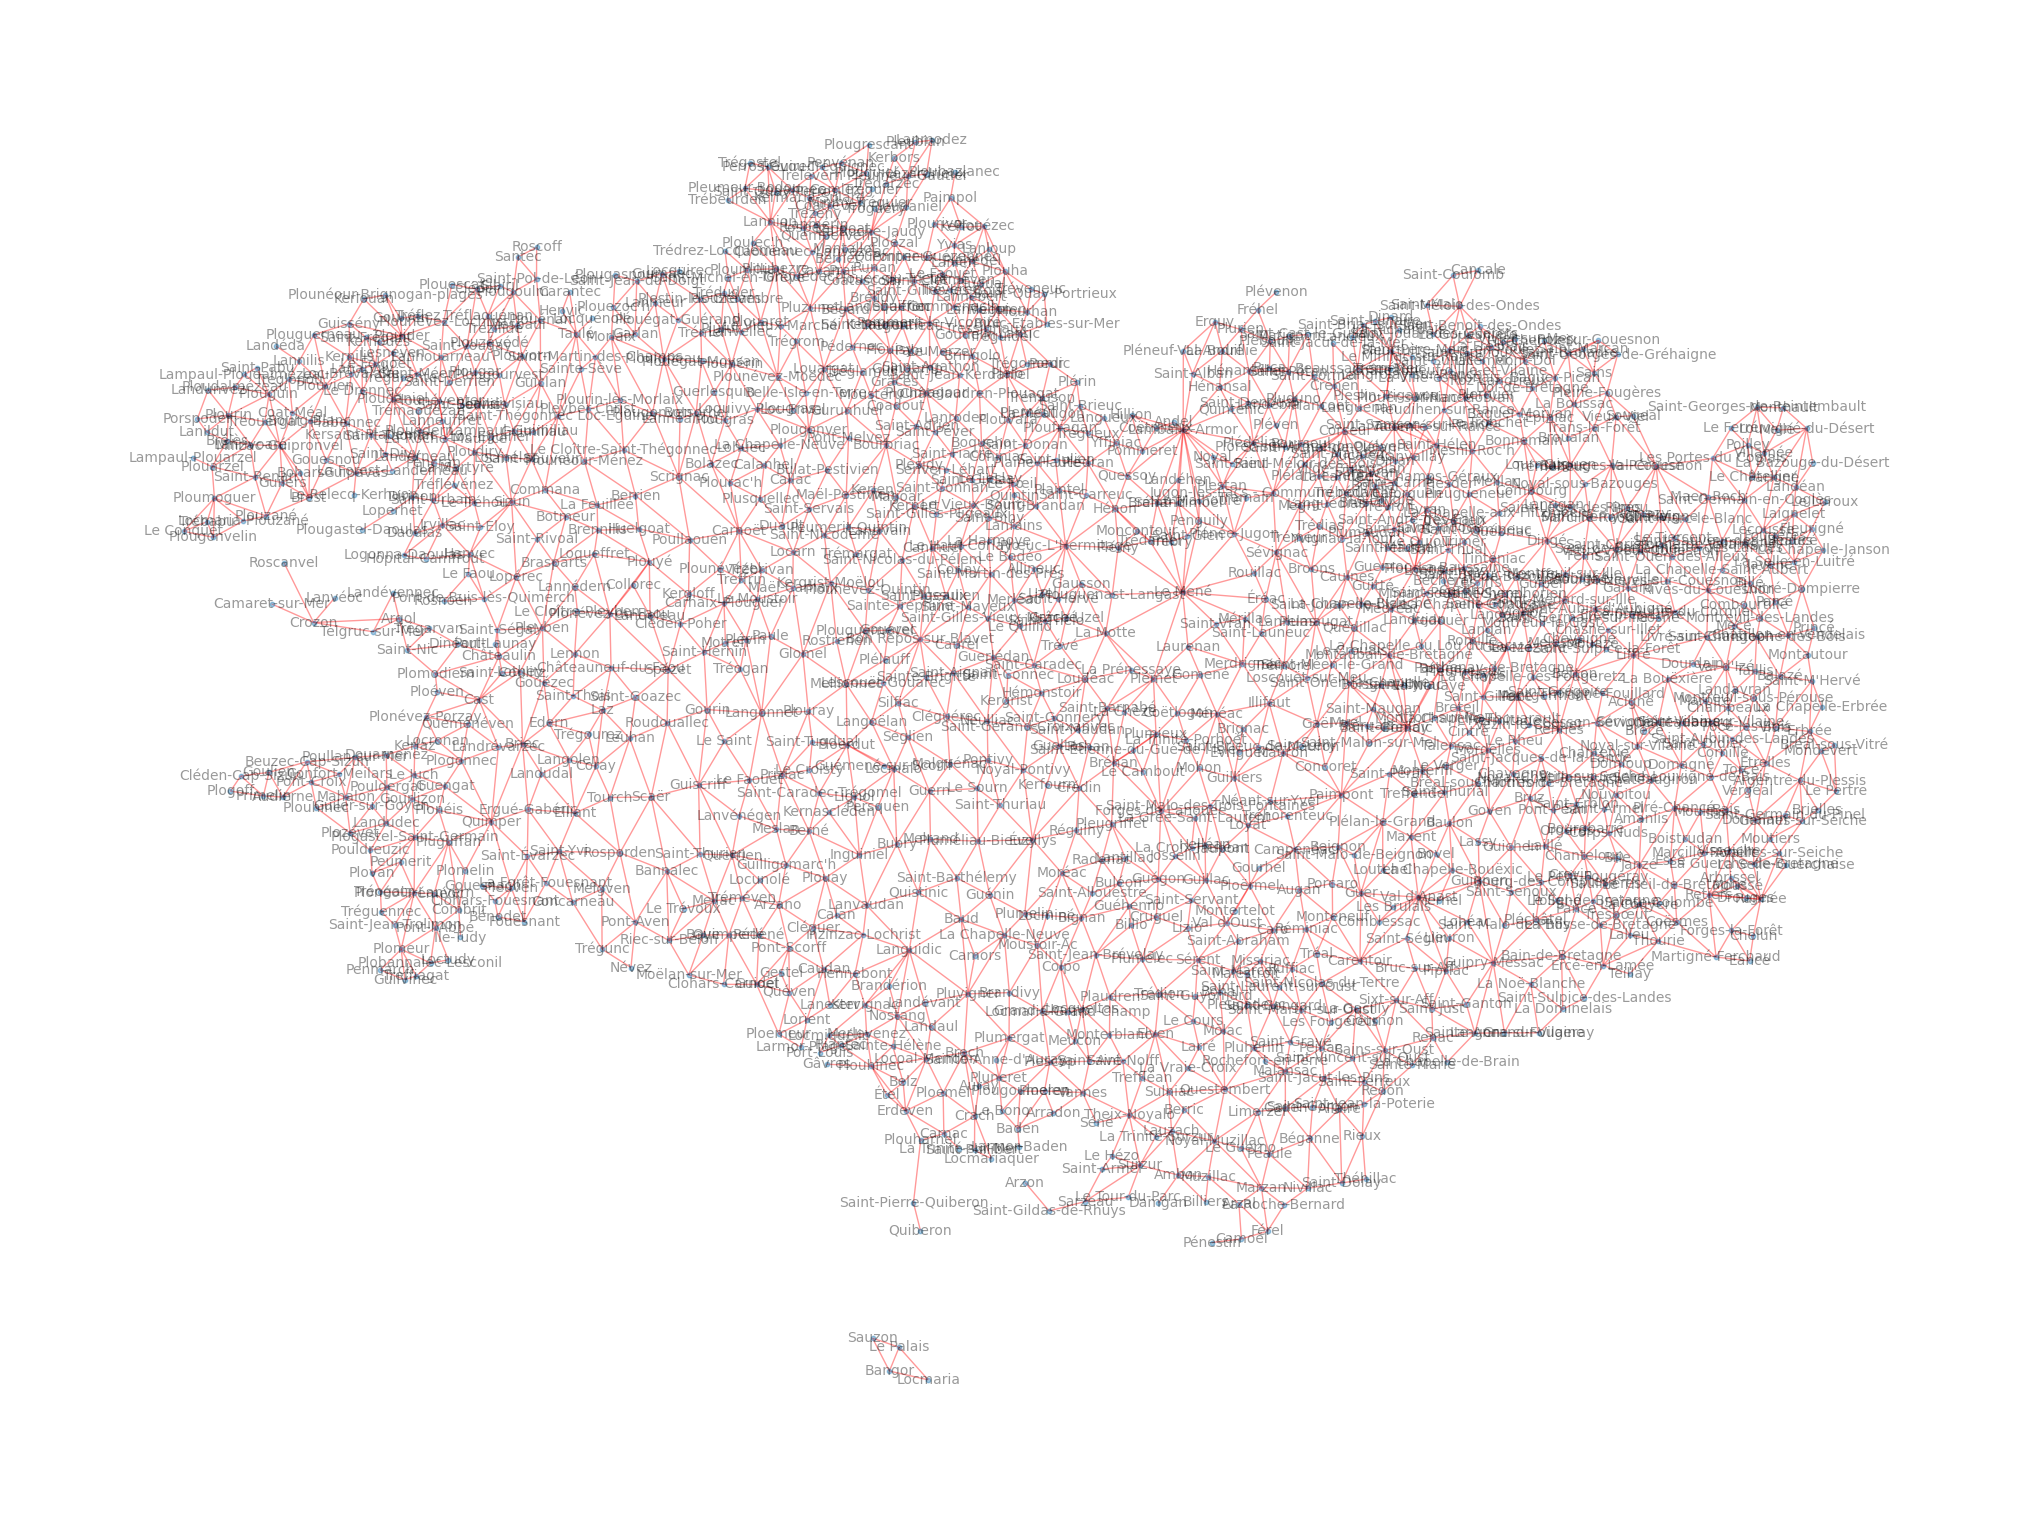

In [14]:
nx.draw(G,pos=pos_insee,node_size=10, alpha=0.4, edge_color="r", font_size=10, labels=label_insee)

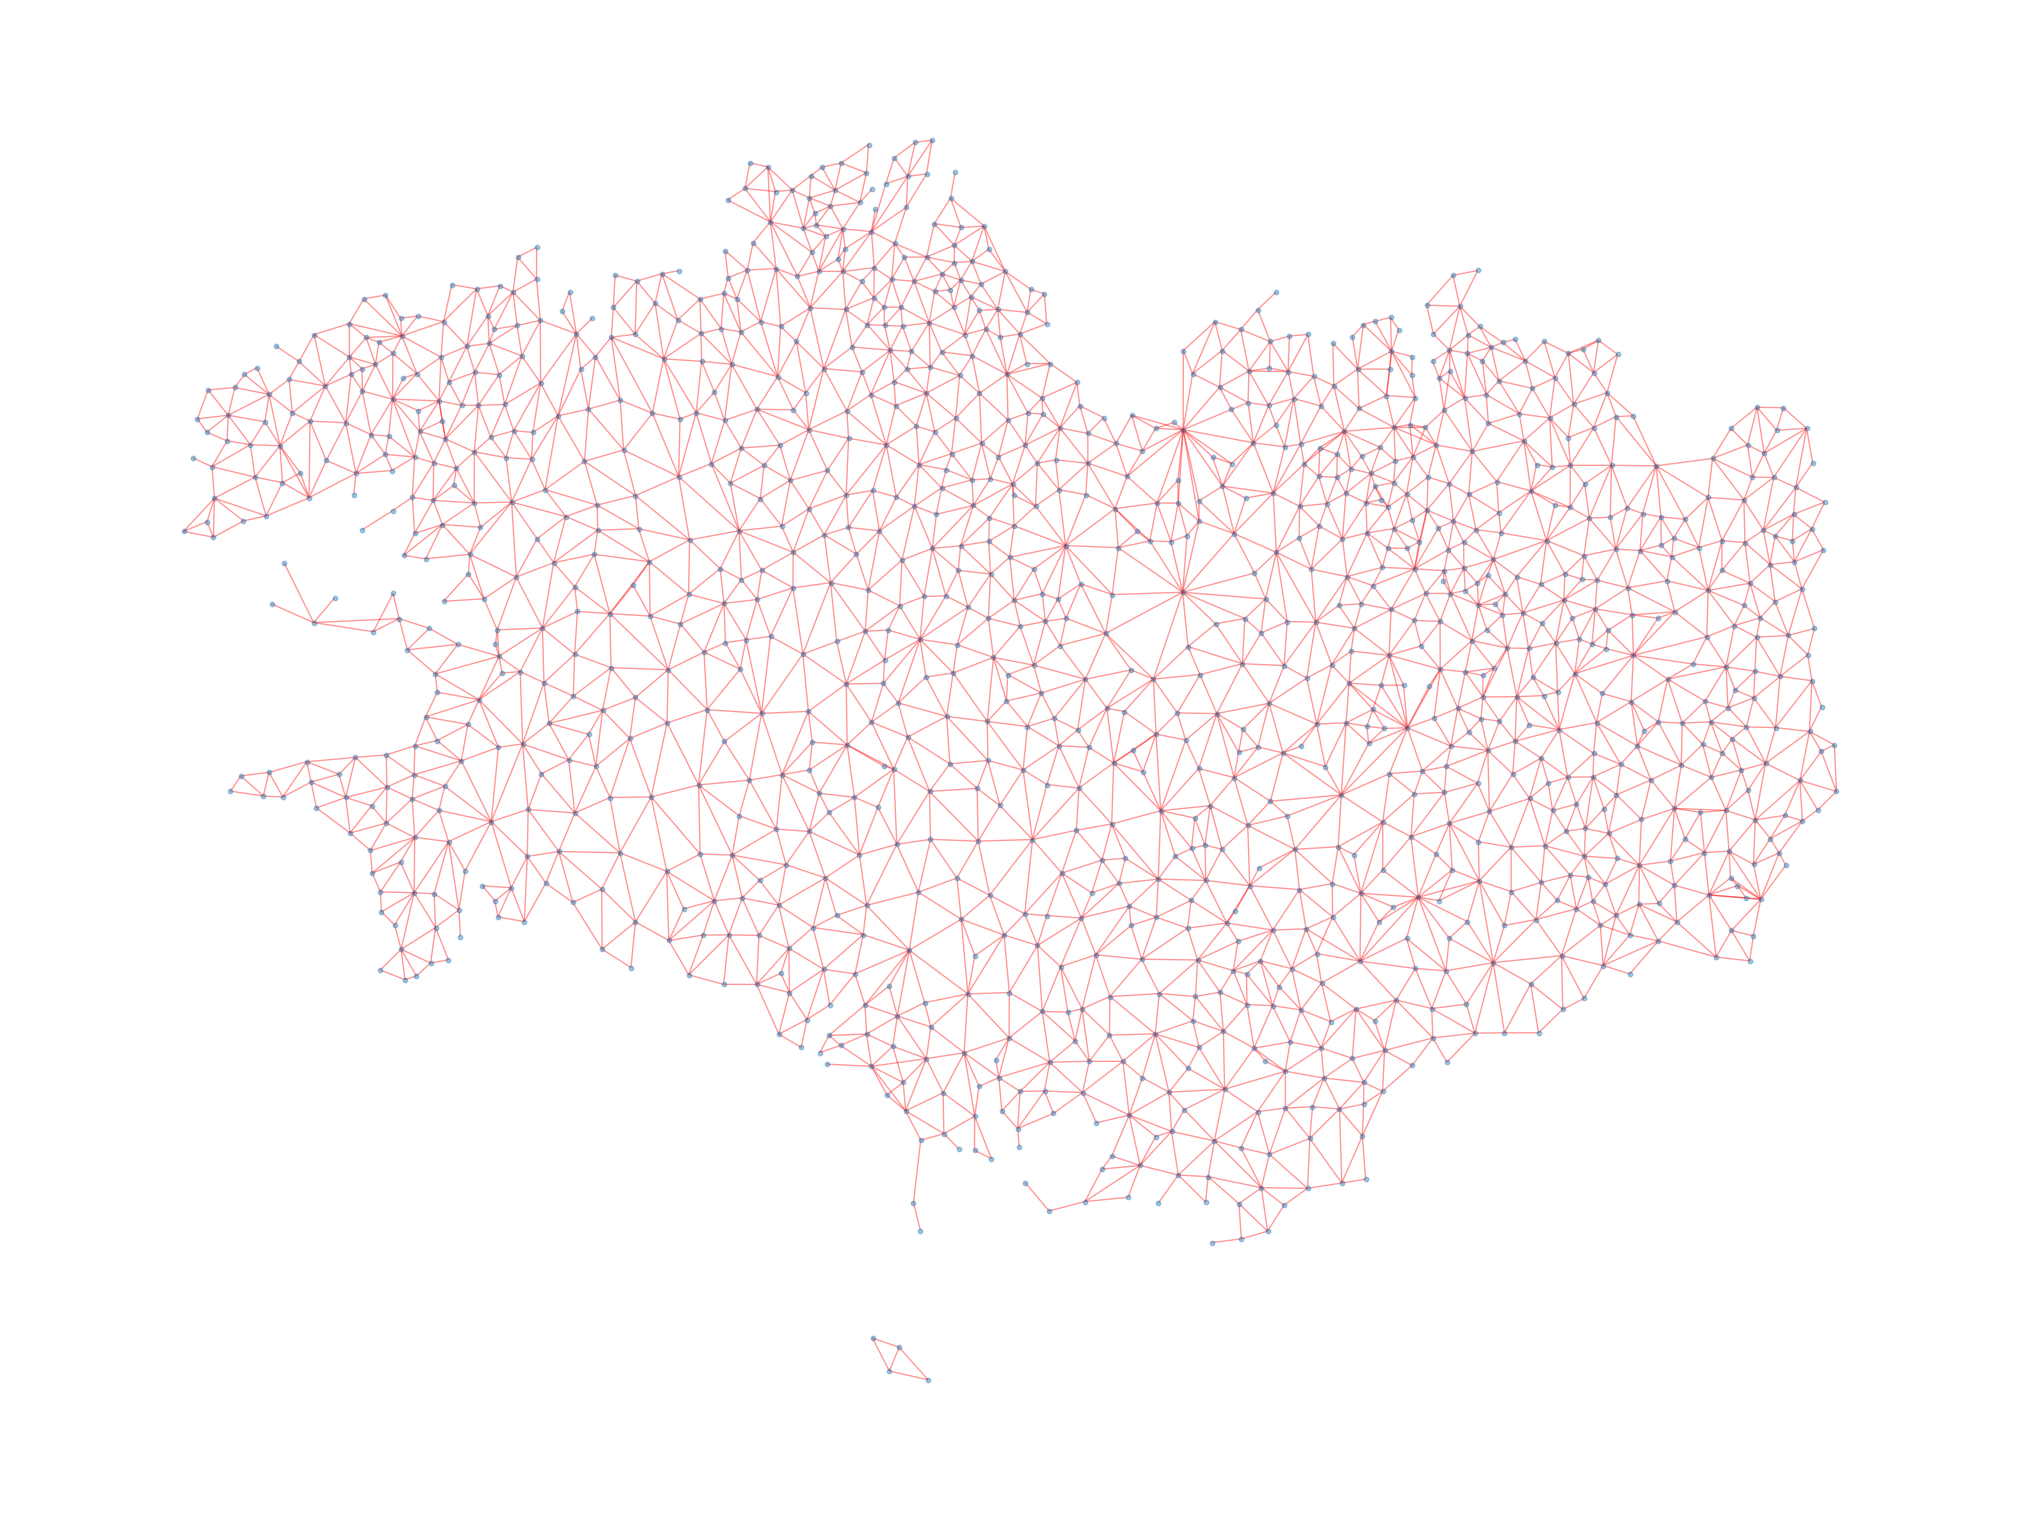

In [15]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
nx.draw(G,pos=pos_insee,node_size=10, alpha=0.4, edge_color="r", font_size=16, with_labels=False)

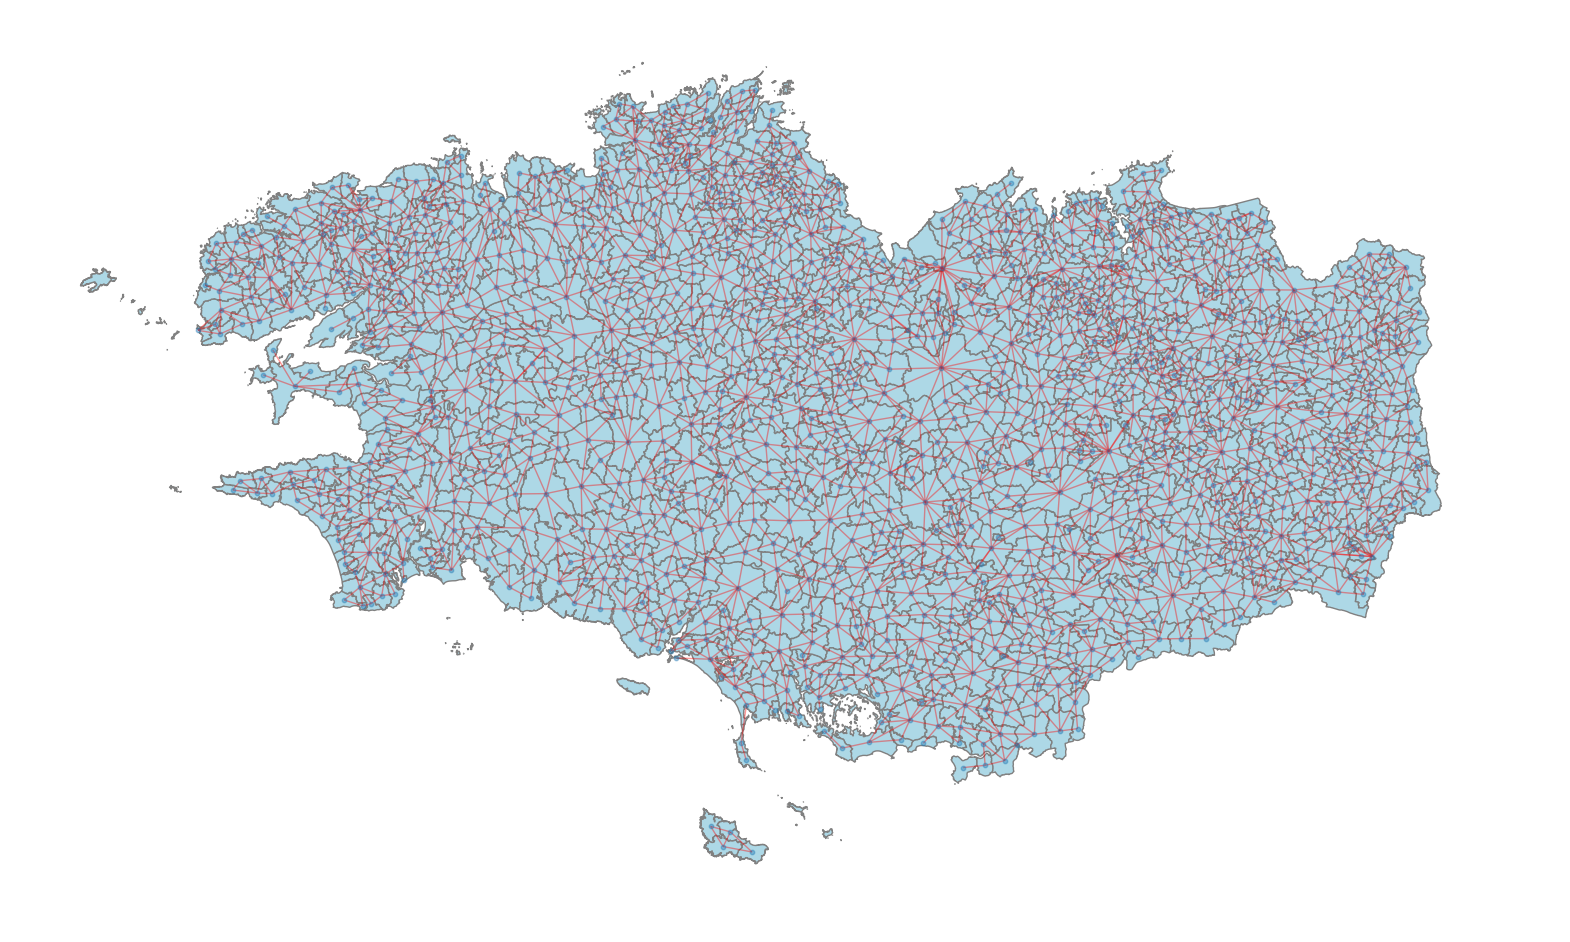

In [16]:
#on peut également utiliser des fonds de carte (via le format geojson par exemple)

import geopandas
region = geopandas.read_file("./DonneesFourniesGraphes/communes-geo.geojson")


plt.close()
# plot with a nice basemap
ax = region.plot(linewidth=1, edgecolor="grey", facecolor="lightblue")
ax.axis("off")
nx.draw(G, pos=pos_insee, ax=ax,node_size=10, alpha=0.4, edge_color="r")
plt.show()

### 4. Méthodes proposées

In [19]:
# Permet de calculer le degré des sommets d'un graphe

def calculate_degrees(G):
    degrees = dict()
    # Création de la liste des voisins pour chaque sommet du graphe
    voisins_dict = {communes['insee'][x] : amezek(x) for x in range(len(communes['insee']))}
    for sommet in G.nodes():
        # Le nombre de degrés d'un graphe est égal au nombre de voisins de celui-ci
        degrees[sommet] = len(voisins_dict[sommet])
    return degrees

degrees = calculate_degrees(G)

for sommet, ecc in degrees.items():
    print("Degrés de " + str(sommet) + " : " + str(ecc))

Degrés de 22001 : 4
Degrés de 22002 : 2
Degrés de 22003 : 4
Degrés de 22004 : 7
Degrés de 22005 : 5
Degrés de 22006 : 4
Degrés de 22055 : 3
Degrés de 22008 : 5
Degrés de 22009 : 6
Degrés de 22011 : 7
Degrés de 22012 : 5
Degrés de 22013 : 9
Degrés de 22014 : 6
Degrés de 22015 : 7
Degrés de 22018 : 6
Degrés de 22019 : 6
Degrés de 22020 : 6
Degrés de 22021 : 7
Degrés de 22023 : 5
Degrés de 22024 : 5
Degrés de 22025 : 7
Degrés de 22026 : 7
Degrés de 22027 : 4
Degrés de 22028 : 7
Degrés de 22029 : 8
Degrés de 22030 : 5
Degrés de 22031 : 10
Degrés de 22032 : 8
Degrés de 22033 : 5
Degrés de 22034 : 7
Degrés de 22035 : 5
Degrés de 22036 : 5
Degrés de 22037 : 5
Degrés de 22206 : 6
Degrés de 22039 : 4
Degrés de 22040 : 5
Degrés de 22041 : 4
Degrés de 22042 : 6
Degrés de 22043 : 5
Degrés de 22044 : 4
Degrés de 22045 : 5
Degrés de 22046 : 2
Degrés de 22047 : 5
Degrés de 22048 : 11
Degrés de 22049 : 6
Degrés de 22050 : 4
Degrés de 22084 : 9
Degrés de 22052 : 5
Degrés de 22053 : 6
Degrés de 22054 : 

In [21]:
# Permet de calculer l'eccentricité des sommets d'un graphe

def calculate_eccentricity(G):
    eccentricities = dict()
    for sommet in G.nodes():
        try:
            # Calcule de la longueur du chemin le plus court entre le sommet actuel et tous les autres via dijkstra
            distances = nx.single_source_dijkstra_path_length(G, sommet)
            
            # L'excentricité d'un sommet est la distance max qui le sépare de tout autre sommet
            eccentricities[sommet] = max(distances.values())
            ### CODER DIJKSTRA SOIT-MEME ###
            ### MIEUX QUE DIJKSTRA EXISTE, UTILISER CA + LE CODER SOI-MEME ###
        except nx.NetworkXNoPath:
            # S'il n'y a pas de chemin entre le sommet et un autre sommet
            eccentricities[sommet] = None
    return eccentricities

eccentricities = calculate_eccentricity(G)

for sommet, ecc in eccentricities.items():
    if ecc is not None: # On s'assure que ce n'est pas None (aucun chemin entre le sommet et un autre sommet)
        print("Excentricité de " + str(sommet) + " : " + str(ecc))


Excentricité de 22001 : 25
Excentricité de 22002 : 29
Excentricité de 22003 : 32
Excentricité de 22004 : 29
Excentricité de 22005 : 29
Excentricité de 22006 : 31
Excentricité de 22055 : 27
Excentricité de 22008 : 33
Excentricité de 22009 : 24
Excentricité de 22011 : 24
Excentricité de 22012 : 30
Excentricité de 22013 : 26
Excentricité de 22014 : 30
Excentricité de 22015 : 27
Excentricité de 22018 : 30
Excentricité de 22019 : 25
Excentricité de 22020 : 30
Excentricité de 22021 : 32
Excentricité de 22023 : 28
Excentricité de 22024 : 30
Excentricité de 22025 : 29
Excentricité de 22026 : 34
Excentricité de 22027 : 27
Excentricité de 22028 : 33
Excentricité de 22029 : 24
Excentricité de 22030 : 31
Excentricité de 22031 : 29
Excentricité de 22032 : 31
Excentricité de 22033 : 23
Excentricité de 22034 : 30
Excentricité de 22035 : 34
Excentricité de 22036 : 32
Excentricité de 22037 : 29
Excentricité de 22206 : 25
Excentricité de 22039 : 27
Excentricité de 22040 : 27
Excentricité de 22041 : 30
E

In [19]:
def diameter(G: nx.Graph) -> int:
    """
    :param G: A NetworkX graph
    :returns: diameter of the graph
    """
    eccentricities = calculate_eccentricity(G)
    return max(eccentricities.values())

print(diameter(G))

44


In [20]:
def radius(G: nx.Graph) -> int:
    """
    :param G: A NetworkX graph
    :returns: radius of the graph
    """
    eccentricities = calculate_eccentricity(G)
    return min(eccentricities.values())

print(radius(G))

1


In [21]:
def centrality_closeness(G: nx.Graph) -> dict:
    return nx.closeness_centrality(G)

In [22]:
def centrality_betweenness(G: nx.Graph) -> dict:
    return nx.betweenness_centrality(G)

In [23]:
def composantes_connexes(G: nx.Graph):
    return nx.connected_components(G)

def plus_grande_composante_conenxe(G: nx.Graph):
    return max(composantes_connexes(G), key=len)

In [24]:
def composantes_fortement_connexes(G: nx.Graph):
    return nx.strongly_connected_components(G)

def plus_grande_composante_fortement_conenxe(G: nx.Graph):
    return max(composantes_connexes(G), key=len)

In [25]:
def ponts(G: nx.Graph): 
    return nx.bridges(G)

In [26]:
def coefficient_clustering(G: nx.Graph):
    return nx.clustering(G)

### 5. Visualisations

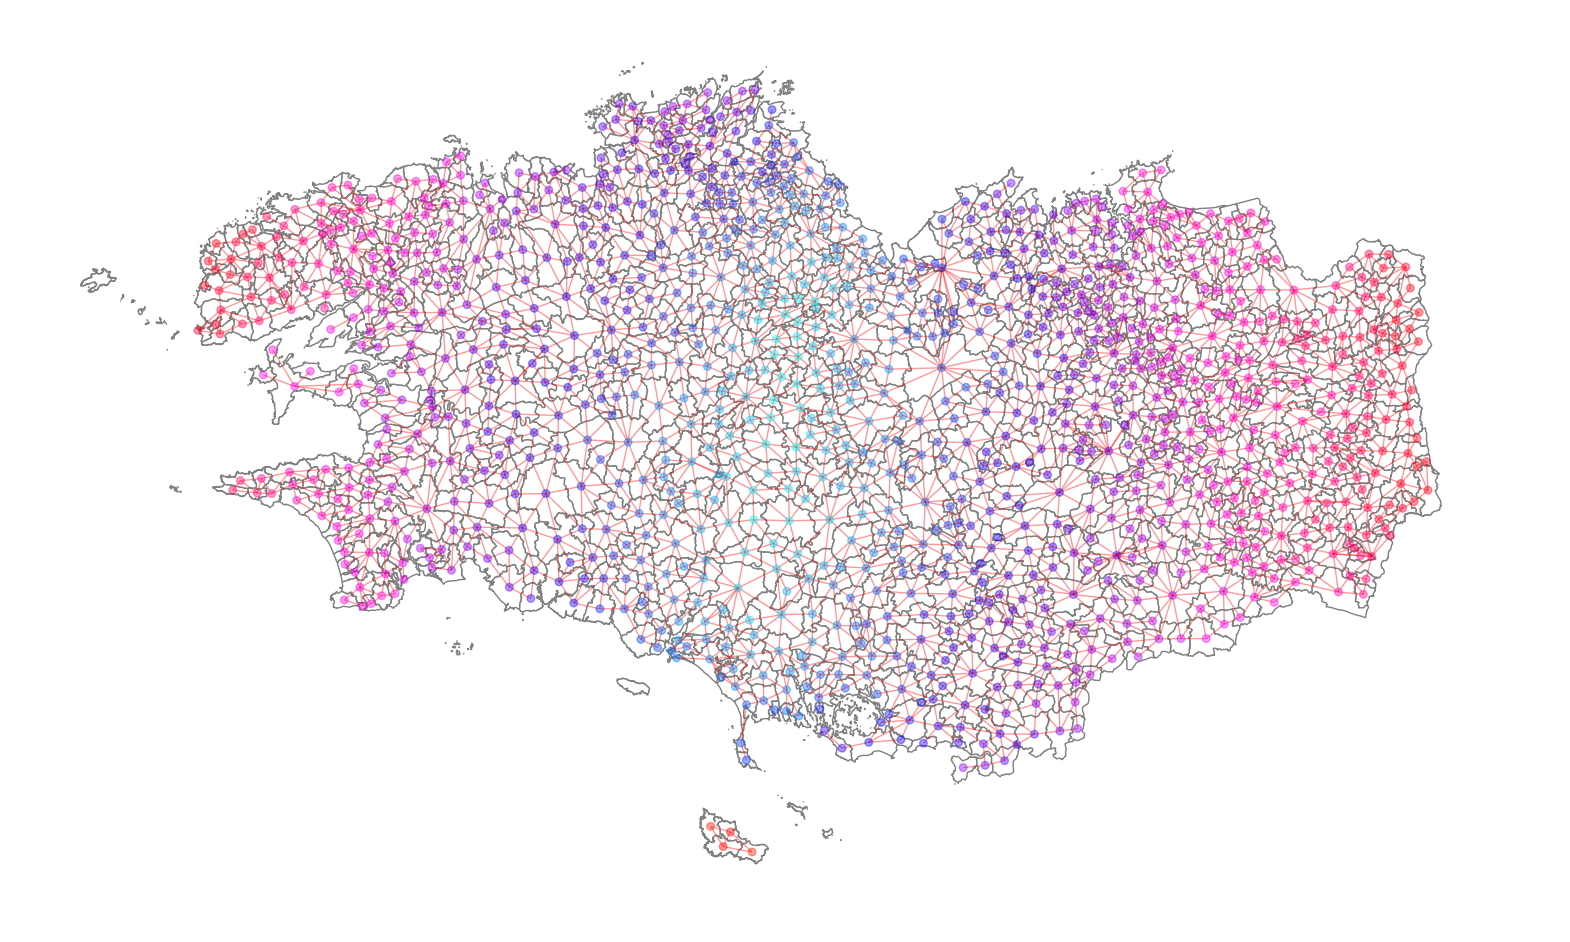

In [27]:
# Création d'une visualisation à partir de l'eccentricité

plt.close()
ax = region.plot(linewidth=1, edgecolor="grey", facecolor="white")
ax.axis("off")
cmap = plt.get_cmap('hsv')  # Choix de la colormap
nx.draw(G, cmap=cmap, pos=pos_insee, ax=ax,node_size=30, alpha=0.4, edge_color="r", node_color=tuple(eccentricities.values()))

norm = plt.Normalize(min(eccentricities.values()), max(eccentricities.values()))

# Ajout d'une barre de couleur
# plt.colorbar(img, ax=ax, orientation="vertical") ### A FIXER ### 

plt.show()

plt.close()

### 6. Section technique

In [20]:
import networkx as nx
import math
import heapq

def euclidean_distance(node1, node2):
    # Cette fonction calcule la distance euclidienne entre deux nœuds.
    # Pour un graphe non spatial, elle retourne 0.
    return 0

def a_star(graph, start):
    # Implémentation de l'algorithme A* pour trouver les chemins les plus courts dans un graphe pondéré.
    
    # Initialisation du tas avec le nœud de départ et son coût initial
    open_set = [(0, start)]
    heapq.heapify(open_set)

    # Initialisation des coûts g avec l'infini pour tous les nœuds sauf le nœud de départ
    g_costs = {node: float('inf') for node in graph.nodes}
    g_costs[start] = 0

    # Boucle principale de l'algorithme A*
    while open_set:
        # Extraire le nœud avec le coût le plus bas actuel depuis le tas
        current_cost, current_node = heapq.heappop(open_set)

        for neighbor in graph.neighbors(current_node):
            # Parcourir tous les voisins du nœud actuel
            edge_weight = graph[current_node][neighbor].get('weight', 1)
            # Coût du chemin tentative pour atteindre le voisin à travers le nœud actuel
            tentative_g_cost = g_costs[current_node] + edge_weight

            # Mettre à jour le coût g si ce chemin est meilleur que tout chemin précédent connu
            if tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                # Coût total estimé f en ajoutant le coût g et la distance estimée h (ici 0)
                f_cost = tentative_g_cost + euclidean_distance(neighbor, start)
                # Ajouter le voisin avec son coût estimé f dans le tas
                heapq.heappush(open_set, (f_cost, neighbor))
    # Retourner les coûts g les plus bas connus pour atteindre chaque nœud à partir du nœud de départ
    return g_costs

def calculate_eccentricity2(G):
    # Cette fonction calcule l'excentricité de chaque nœud dans le graphe G en utilisant l'algorithme A*.
    
    eccentricities = dict() # Dictionnaire pour stocker les excentricités calculées
    
    # Boucle sur tous les nœuds du graphe G
    for sommet in G.nodes():
        try:
            # Appliquer l'algorithme A* pour calculer les distances les plus courtes à partir du nœud sommet
            distances = a_star(G, sommet)
            # L'excentricité est le maximum des coûts trouvés dans distances
            eccentricities[sommet] = max(distances.values())
        except nx.NetworkXNoPath:
            # Si aucun chemin n'est trouvé, l'excentricité est définie comme None
            eccentricities[sommet] = None
            
    # Retourner le dictionnaire d'excentricités calculées pour chaque nœud        
    return eccentricities


# Création d'un petit graphe pour tester
G_simple = nx.Graph()
G_simple.add_edges_from([(1, 2, {'weight': 1}), (2, 3, {'weight': 2}), (1, 3, {'weight': 3})])

# Calcul des excentricités pour le graphe simple
eccentricities_simple = calculate_eccentricity2(G_simple)

# Affichage des résultats
for node, ecc in eccentricities_simple.items():
    if ecc is not None:
        print(f"Excentricité de {node}: {ecc}")
        
degrees = calculate_eccentricity2(G)

for sommet, ecc in degrees.items():
    print("Degrés de " + str(sommet) + " : " + str(ecc))

Excentricité de 1: 3
Excentricité de 2: 2
Excentricité de 3: 3
Degrés de 22001 : inf
Degrés de 22002 : inf
Degrés de 22003 : inf
Degrés de 22004 : inf
Degrés de 22005 : inf
Degrés de 22006 : inf
Degrés de 22055 : inf
Degrés de 22008 : inf
Degrés de 22009 : inf
Degrés de 22011 : inf
Degrés de 22012 : inf
Degrés de 22013 : inf
Degrés de 22014 : inf
Degrés de 22015 : inf
Degrés de 22018 : inf
Degrés de 22019 : inf
Degrés de 22020 : inf
Degrés de 22021 : inf
Degrés de 22023 : inf
Degrés de 22024 : inf
Degrés de 22025 : inf
Degrés de 22026 : inf
Degrés de 22027 : inf
Degrés de 22028 : inf
Degrés de 22029 : inf
Degrés de 22030 : inf
Degrés de 22031 : inf
Degrés de 22032 : inf
Degrés de 22033 : inf
Degrés de 22034 : inf
Degrés de 22035 : inf
Degrés de 22036 : inf
Degrés de 22037 : inf
Degrés de 22206 : inf
Degrés de 22039 : inf
Degrés de 22040 : inf
Degrés de 22041 : inf
Degrés de 22042 : inf
Degrés de 22043 : inf
Degrés de 22044 : inf
Degrés de 22045 : inf
Degrés de 22046 : inf
Degrés de 220

### 6. Scénarios proposés

####  Scénario 1 : Commune X se lie aux Y communes les plus importantes de Bretagne :

Pour ce scénario, nous avons besoin de deux choses :

Identifier les Y communes les plus importantes en termes de centralité et trouver le chemin le plus court de la commune X à chacune de ces Y communes.


Comment nous allons faire :

1. Centralité de Degré (Degree Centrality) :
     - Cette centralité mesure le nombre de liens qu'une commune a. 
     - Plus ce nombre est élevé, plus la commune est importante en termes de connexions directes.
     - Utilisation : Pour trouver les Y communes les plus importantes en termes de liens directs.
    
    
2. Chemin le plus court (Shortest Path) :
    - Utilisation de l'algorithme de Dijkstra pour trouver le chemin le plus court entre une commune X et une commune Y.
    - A MODIFIER, N'EST PAS L'ALGORTIHME DE DIJKSTRA

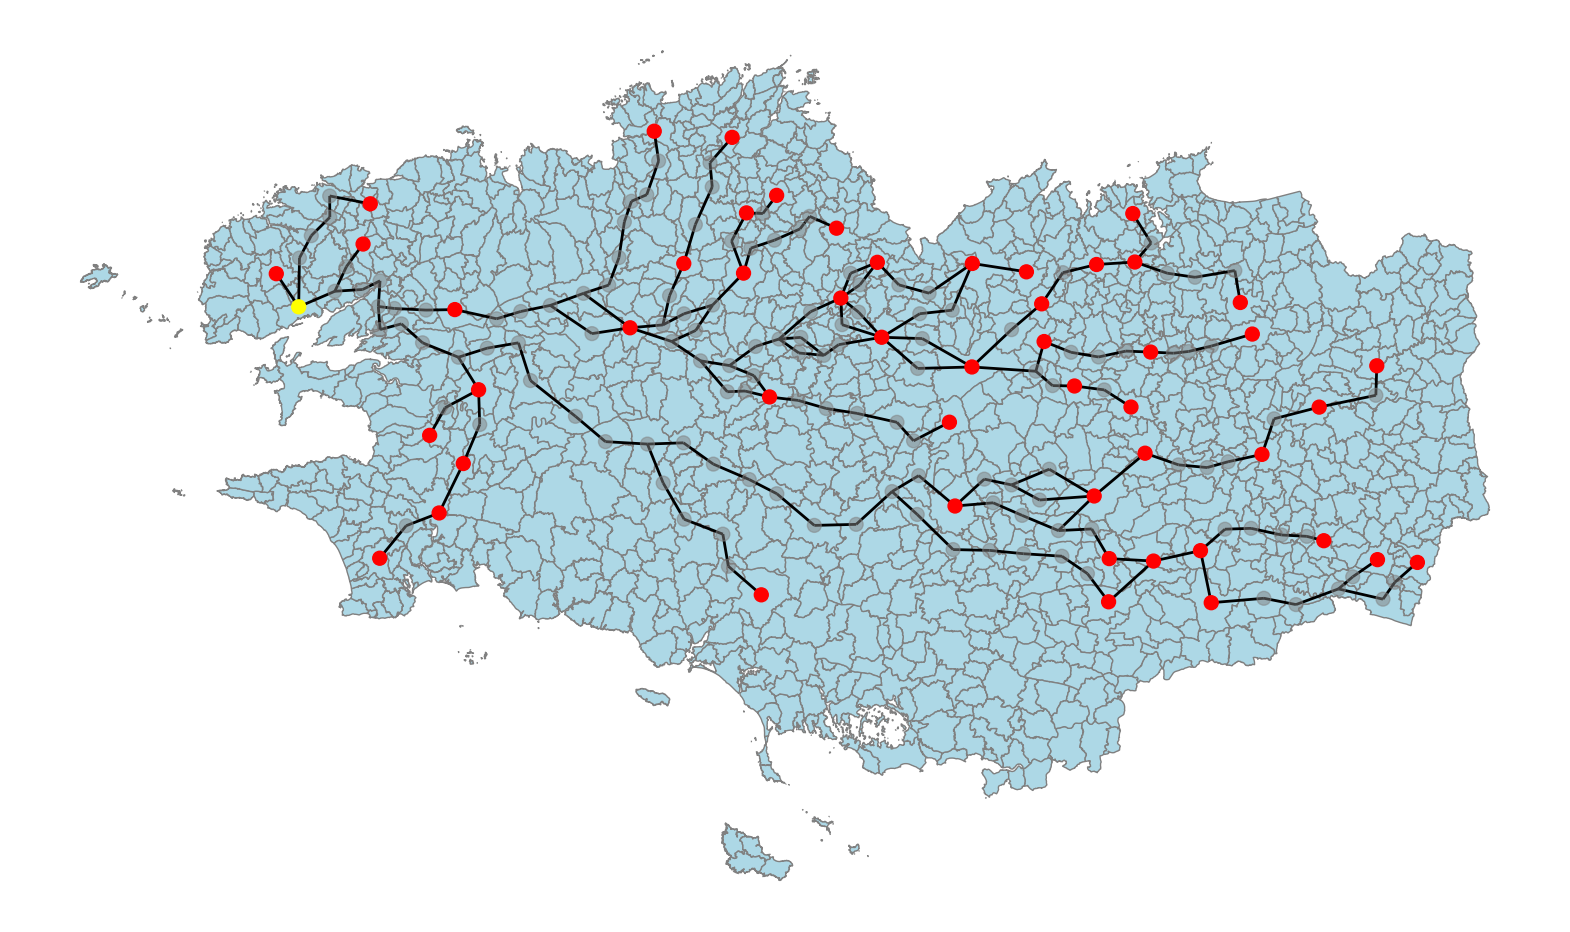

In [78]:
def draw_top_Y_communes(G, X, amount_Y):
    new_G = nx.Graph()
    top_Y_communes = get_top_Y_communes(G, amount_Y)
    for Y in top_Y_communes :
        shortest_path, shortest_distance = chemin_plus_court_de_X_vers_Y(G, X, Y)
        for i in range(len(shortest_path) - 1):
            new_G.add_edge(shortest_path[i], shortest_path[i + 1])
            
    color_map = []
    alpha_map = []
    for node in new_G:
        if node == X:
            color_map.append('yellow')
            alpha_map.append(1)
        elif node in top_Y_communes:
            color_map.append('red')
            alpha_map.append(1)
        else:
            color_map.append('grey')
            alpha_map.append(0.50)

    region = geopandas.read_file("./DonneesFourniesGraphes/communes-geo.geojson")

    plt.close()
    # plot with a nice basemap
    ax = region.plot(linewidth=1, edgecolor="grey", facecolor="lightblue")
    ax.axis("off")
    nx.draw_networkx_nodes(new_G, node_color=color_map, pos=pos_insee, ax=ax, node_size=100, alpha=alpha_map)
    nx.draw_networkx_edges(new_G, edge_color="black", pos=pos_insee, ax=ax, width=2.0, alpha=1)
    plt.show()

def get_top_Y_communes(G, Y):
    degree_centralities = nx.degree_centrality(G)
    top_Y_communes = sorted(degree_centralities, key=degree_centralities.get, reverse=True)[:Y]
    return top_Y_communes

def chemin_plus_court_de_X_vers_Y(G, commune_X, commune_Y):
    try:
        # même pas l'algorithme de dijkstra 
        shortest_path = nx.shortest_path(G, source=commune_X, target=commune_Y)
        shortest_distance = nx.shortest_path_length(G, source=commune_X, target=commune_Y)
        return shortest_path, shortest_distance
    except nx.NetworkXNoPath:
        return None, float('inf')

# Exemple d'utilisation
top_Y = 50  # Nombre de communes les plus importantes à trouver
commune_X = 29019 # Commune qu'on souhaite relier à ces Y communes
draw_top_Y_communes(G, commune_X, top_Y)

####  Scénario 2 : Identifier les lignes de chemin de fer les plus importantes à garder aux normes :

Pour ce scénario, nous devons identifier les arêtes les plus importantes du graphe, probablement en utilisant une forme de centralité qui met en évidence l'importance des connexions dans le réseau.


Comment nous allons faire :

1. Centralité d'Intermédiarité (Betweenness Centrality) :
    - Mesure la fréquence à laquelle un nœud se trouve sur le chemin le plus court entre deux autres nœuds.
    - Utilisation : Identifier les arêtes (connexions) les plus importantes qui relient différentes parties du réseau.

In [30]:
def arretes_importantes(G):
    betweenness_centralities = nx.edge_betweenness_centrality(G)
    important_edges = sorted(betweenness_centralities, key=betweenness_centralities.get, reverse=True)
    return important_edges

# Exemple d'utilisation
important_edges = arretes_importantes(G)
print("Arêtes les plus importantes :")
for edge in important_edges[:10]:  # Afficher les 10 arêtes les plus importantes
    print(edge)

Arêtes les plus importantes :
(56173, 56144)
(22046, 22185)
(35133, 35211)
(22031, 22128)
(56066, 56100)
(56173, 56076)
(22087, 22128)
(56047, 56144)
(29278, 56066)
(22048, 22339)
